In [1]:
import numpy as np
import sep
import glob
import pandas as pd
from astropy.table import Table

In [1]:
from pfs.lam.fileHandling import *
from pfs.lam.instrModelAlign import peakdet
from pfs.lam.linePeaksList import *

In [3]:
import pfs.opdb as opdb
import lsst.daf.persistence as dafPersist

In [4]:
# additional setup for reading the test image and displaying plots
#import fitsio
#%matplotlib widget

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm



rcParams['figure.figsize'] = [10., 8.]
rcParams["scatter.marker"] = '+'

In [5]:
plt.style.use('dark_background')

# INPUTS

In [6]:
doSave = False

## say which fibers were used

In [7]:
slitMapFile = "/home/pfs/dev/ait-notebook/optical/input/Slit-mapping-connectors2018.xlsx"
fiber = pd.read_excel(slitMapFile, header=0, sheet_name="SM1_DCB")

#fiberCenter = fiber[(fiber["DCB"] == "red1") | (fiber["DCB"] == "red8") | (fiber["DCB"] == "red4") | (fiber["DCB"] == "green") ]
fiberCenter = fiber[(fiber["DCB"] == "engineering")]

listfiber = fiberCenter.sort_values(["Fiber"], ascending=False).Fiber.values

## Arc file experiment Id

In [8]:
rerun = "ws_slit"
#rerun = "dcb2"

repo = "sps"
cam = "r3"
arm = cam[0]
drpPath = "/data/drp"

In [9]:
butler = dafPersist.Butler(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")

In [14]:
experimentId = 190 # 1339

## Flat file experiment Id

In [ ]:
FlatId = 112#1353 #1179 #947

# Process arc

In [15]:
visitStart, visitEnd = opdb.getVisitRange(experimentId)
visit = int(visitStart)+0

In [17]:
image_file = butler.getUri("calexp", visit=visit, arm=arm)

In [18]:
#image_file = filelist.filepath.iloc[0]
print(image_file)

/data/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-26/v024258/calExp-LA024258r3.fits


In [19]:
hdul = fits.open(image_file)
data = hdul[1].data

In [20]:
threshold = 50
objects = sep.extract(data, threshold) #, filter_kernel=None)

In [21]:
# how many objects were detected
len(objects)

414

In [22]:
## use ginga remote control client

%matplotlib notebook

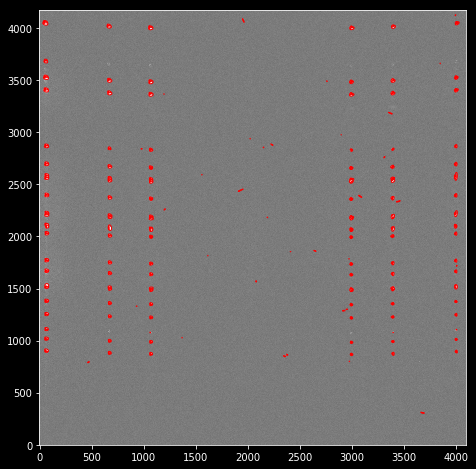

In [23]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data), np.std(data)
im = ax.imshow(data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [24]:
df = pd.DataFrame(objects, columns=objects.dtype.names)

In [25]:
df = df.rename(columns={'x': 'px','y': 'py', 'peak': 'brightness'})

In [26]:
df["attenuator"] = getFitsKey(image_file,"W_AITATT")
df["source"] = getSourcesUsed(image_file)
df["exptime"] = getFitsKey(image_file,"EXPTIME")
df["ignore"] = 0

# Remove peaks too close to each others

Using scipy spatial module:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query_ball_point.html#scipy.spatial.KDTree.query_ball_point

In [ ]:
df.loc[(df.py> 2600) | (df.py< 2300), "ignore"] = 1

In [ ]:
df.loc[(df.py> 4140) | (df.py< 4000), "ignore"] = 1

In [ ]:
df.plot.scatter(x="px", y="py", s=180)
print(len(df))

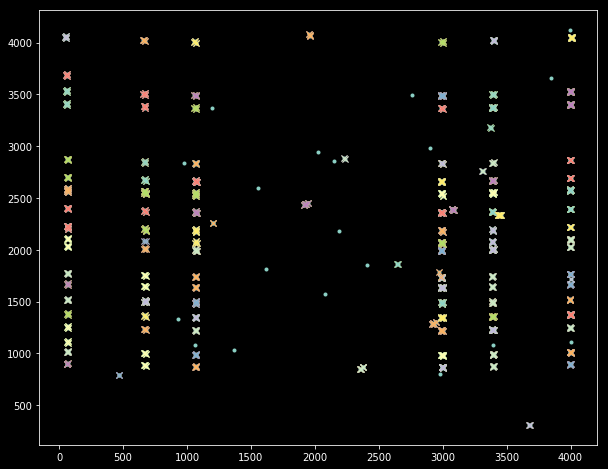

In [30]:
dist = 50 # 80 for thFocus, can be decrease for imquality
df = removeClosePeak(df, dist=dist ,doPlot=True)

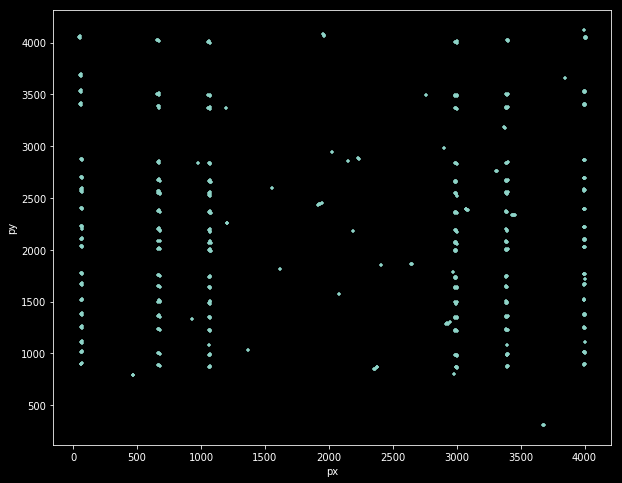

In [31]:
df = removeFluxPeak(df, fmin=100, fmax=65000, doPlot=True)

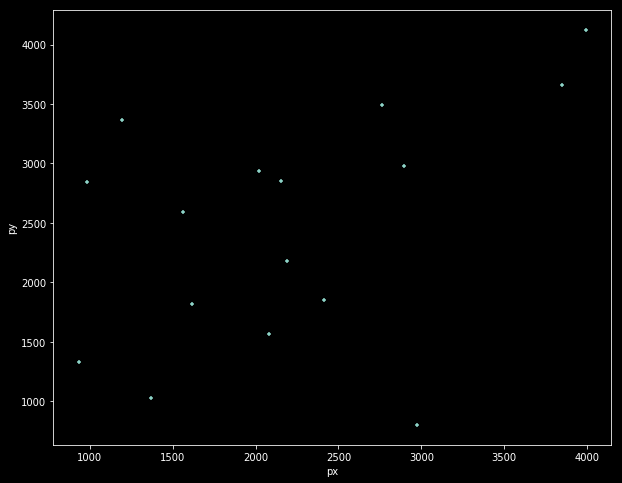

In [33]:
ax= df.where(df.ignore<1).plot.scatter(x="px", y="py")

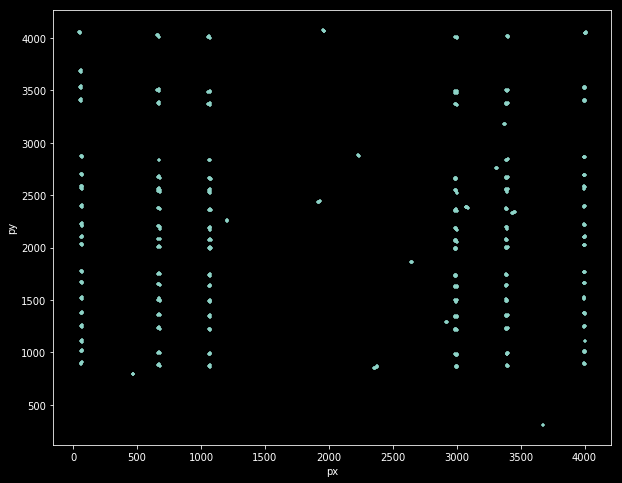

In [32]:
df.where(df.flag==1).plot.scatter(x="px", y="py")

# identify fiber from Flat

In [ ]:
visitStart, visitEnd = opdb.getVisitRange(FlatId)
visit = int(visitStart)

In [ ]:
flat_image_file = butler.getUri("calexp", visit=visit, arm=arm)

In [ ]:
from astropy.io import fits
fits.info(flat_image_file)

In [ ]:
image_data = fits.getdata(flat_image_file, ext=1)

In [ ]:
print(image_data.shape)

In [ ]:
fig, ax = plt.subplots()
m, s = np.mean(image_data), np.std(image_data)
im = ax.imshow(image_data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')


In [ ]:
indxs = np.linspace(2610, 4010, num=2)  # <=> y in the real image
indxs

In [ ]:
#line = []
f_pos = []
for indx in indxs :
    indx = np.int(indx)
    line = image_data[indx, :]
    plt.plot(line)
    pos, a = peakdet(line, 120)
    print(len(pos))
    pos = pos[:,0]
    f_pos.append(pos)

In [ ]:
a = np.array(f_pos)
a.shape

In [ ]:
a[:,0]

In [ ]:
popt = []
for i in range(a.shape[1]):
    x  = a[:,i]
    popt.append(np.polyfit(indxs, x, 3))

In [ ]:
y = np.arange(4000)
fig, ax = plt.subplots()
plt.plot(np.polyval(popt[0], y),y)
plt.show()

In [ ]:
thresh = 20
df["fiber"] = None
for (px, py),group in df.groupby(["px","py"]):
    
    delta = np.abs(np.array([np.polyval(popt[i], py) for i in range(len(popt))]) - px)
    #print(np.min((delta)))
    if np.min(delta) > thresh : 
        df.loc[(df.px == px) & (df.py == py), "ignore"] = 1
        df.loc[(df.px == px) & (df.py == py), "fiber"] = np.nan
    else:
        df.loc[(df.px == px) & (df.py == py), "fiber"] = listfiber[np.argmin(delta)]

In [ ]:
df.fiber.unique()

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(df.fiber.unique())))

grouped = df.groupby('fiber')
for i,(key, group) in enumerate(grouped):
    group.plot(ax=ax, kind='scatter', x='px', y='py', color=colors[i])
    plt.plot(np.polyval(popt[i], y),y, color=colors[len(df.fiber.unique())-i-1])

plt.show()

#df.plot.scatter(x="px", y="py", c=True)

In [ ]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(df.fiber.unique())))

grouped = df.where(df.ignore<1).dropna().groupby('fiber')
for i,(key, group) in enumerate(grouped):
    group.plot(ax=ax, kind='scatter', x='px', y='py', color=colors[i])
    plt.plot(np.polyval(popt[i], y),y, color=colors[len(df.fiber.unique())-i-1])

plt.show()

#df.plot.scatter(x="px", y="py", c=True)

In [ ]:
for (X,Y), group in df[df.ignore<1].groupby(["px","py"]):
    canvas.add('circle',float(X),float(Y), radius=25, color='orange')

# Create PeakList file


In [ ]:
path = "/home/pfs/dev/ait-notebook/optical/input/"
path = "./"


In [ ]:
listpeaks = df[["brightness", "px", "py", "attenuator", "source", "exptime"]].where(df.ignore<1)


In [ ]:
listpeaks= listpeaks.rename(columns={'px': 'X', 'py': 'Y'})

In [ ]:
listpeaks = listpeaks.dropna().sort_values("X").reset_index()

In [ ]:
listpeaks["fiber"] = listpeaks.index +1
listpeaks["peak"] = 1


In [ ]:
listpeaks

In [ ]:
#listpeaks.drop(['level_0', 'index'], axis=1, inplace=True)
listpeaks.drop(['index'], axis=1, inplace=True)


In [ ]:
listpeaks.to_csv("SM2_peak_dcb2_neon_20201211.csv")

In [ ]:
for (fiber),a in listpeaks.sort_values("X").groupby(["fiber"]):
    l = len(listpeaks[(listpeaks.fiber == fiber)])
#    print(l)
    listpeaks.loc[listpeaks.fiber == fiber, "peak"] = np.arange(1,l+1)

In [ ]:
listpeaks = df[["brightness", "px", "py", "attenuator", "source", "exptime", "fiber" ]].where(df.ignore<1).dropna()
#listpeaks = df[["brightness", "px", "py", "attenuator", "source", "exptime", "fiber" ]]

In [ ]:
listpeaks = df[["brightness", "px", "py", "attenuator", "source", "exptime", "fiber" ]].where(df.ignore<1)
#listpeaks = df[["brightness", "px", "py", "attenuator", "source", "exptime", "fiber" ]]

In [ ]:
listpeaks= listpeaks.rename(columns={'px': 'X', 'py': 'Y'})

In [ ]:
listpeaks = listpeaks.sort_values(['X', 'Y'])

In [ ]:
for (fiber),a in listpeaks.sort_values("X").groupby(["fiber"]):
    l = len(listpeaks[(listpeaks.fiber == fiber)])
#    print(l)
    listpeaks.loc[listpeaks.fiber == fiber, "peak"] = np.arange(1,l+1)

In [ ]:
listpeaks.head()

In [ ]:
fiberCenter.DCB.unique()

In [ ]:
peak_file = "SM1_%s_A_%s_Exp%i_Nov2019.csv"%(filelist.cam[0],df["source"][0],experimentId)
print(peak_file)
if doSave:
    listpeaks.to_csv(path+peak_file)

In [ ]:
path

In [ ]:
peak_file

In [ ]:
# create peak list with all peak
allpeaks = df[["brightness", "px", "py", "attenuator", "source", "exptime", "fiber" ]].dropna()
allpeaks= allpeaks.rename(columns={'px': 'X', 'py': 'Y'})
allpeaks = allpeaks.sort_values(['X', 'Y'])
for (fiber),a in allpeaks.sort_values("X").groupby(["fiber"]):
    l = len(allpeaks[(allpeaks.fiber == fiber)])
#    print(l)
    allpeaks.loc[allpeaks.fiber == fiber, "peak"] = np.arange(1,l+1)

In [ ]:
allpeak_file = "SM1_Blue_sep_%s_Exp%i_all.csv"%(getSourcesUsed(image_file),experimentId)
if doSave:
    allpeaks.to_csv(path+allpeak_file)

In [ ]:
allpeak_file